#  Recruit Restaurant Visitor Forecasting

## Feature Engineering

 The aim of this challenge is to predict the future numbers of restaurant visitors. This makes it a Time Series Forecasting problem. The data was collected from Japanese restaurants. We have chosen this project, because the data set is small and easily accessible.<br>
 The project is very important and interesting for us because it is a real data set, and real business problem.


In this section, we create new variables.Change their types.Check the relevance of each variable for the future model.<br>
let's try!!!

In [3]:
# Load libraries
import numpy as np 
import pandas as pd 
from subprocess import check_output
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
import matplotlib
matplotlib.style.use('ggplot')

## 1.1. Data import and aggregation

The training data covers the dates from 2016 until April 2017. The test set covers the last week of April and May of 2017. The test set is split based on time (the public fold coming first, the private fold following the public) and covers a chosen subset of the air restaurants. Note that the test set intentionally spans a holiday week in Japan called the "Golden Week."

In [4]:
# Data Import
airres = pd.read_csv('../input/air_reserve.csv')
airstore = pd.read_csv('../input/air_store_info.csv')
hpgres = pd.read_csv('../input/hpg_reserve.csv')
hpgstore = pd.read_csv('../input/hpg_store_info.csv')
airvisit = pd.read_csv('../input/air_visit_data.csv')
dates = pd.read_csv('../input/date_info.csv')
wd = pd.read_csv('../input/WeatherData.csv')
rel = pd.read_csv('../input/store_id_relation.csv')
test = pd.read_csv('../input/sample_submission.csv')

In [5]:
airvisit.tail(3)

,air_store_id,visit_date,visitors
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8
252107,air_24e8414b9b07decb,2017-04-22,5


In [6]:
len(airvisit.air_store_id.unique())

829

In [7]:
airvisit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
air_store_id    252108 non-null object
visit_date      252108 non-null object
visitors        252108 non-null int64
dtypes: int64(1), object(2)
memory usage: 5.8+ MB


In [8]:
airres.head(3)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6


In [9]:
hpgstore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
hpg_store_id      4690 non-null object
hpg_genre_name    4690 non-null object
hpg_area_name     4690 non-null object
latitude          4690 non-null float64
longitude         4690 non-null float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


  ## 1.1 Convert the date format and group by date reservation for booking data.

We want to grouping the data by ID and date of visit. Calculate the total number of visitors and the median value of the gap between booking and the day of the restaurant visit

In [10]:
#AIR
vdt = pd.to_datetime(airres.visit_datetime)
rdt = pd.to_datetime(airres.reserve_datetime)
airres['visit_date']=vdt.dt.date
airres['rd']=rdt.dt.date

In [11]:
airres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 6 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null object
reserve_datetime    92378 non-null object
reserve_visitors    92378 non-null int64
visit_date          92378 non-null object
rd                  92378 non-null object
dtypes: int64(1), object(5)
memory usage: 4.2+ MB


In [12]:
airres['air_date_diff'] = airres.apply(lambda r: (r['visit_date'] - r['rd']).days, axis=1)

In [13]:
#airres = airres.groupby(['air_store_id','visit_date'], as_index=False)['reserve_visitors'].sum()
temp1_date_diff_median = airres.groupby(['air_store_id','visit_date'], as_index=False)['air_date_diff'].median()
temp1_date_diff_median.head()

,air_store_id,visit_date,air_date_diff
0,air_00a91d42b08b08d9,2016-10-31,0.0
1,air_00a91d42b08b08d9,2016-12-05,4.0
2,air_00a91d42b08b08d9,2016-12-14,6.0
3,air_00a91d42b08b08d9,2016-12-17,6.0
4,air_00a91d42b08b08d9,2016-12-20,2.0


In [14]:
temp2_airres_visit_sum = airres.groupby(['air_store_id','visit_date'], as_index=False)['reserve_visitors'].sum().rename(
    columns={'reserve_visitors': 'reserve_visitors_air'})
temp2_airres_visit_sum.head()

,air_store_id,visit_date,reserve_visitors_air
0,air_00a91d42b08b08d9,2016-10-31,2
1,air_00a91d42b08b08d9,2016-12-05,9
2,air_00a91d42b08b08d9,2016-12-14,18
3,air_00a91d42b08b08d9,2016-12-17,2
4,air_00a91d42b08b08d9,2016-12-20,4


In [15]:
airresgrupp = pd.merge(temp2_airres_visit_sum,temp1_date_diff_median,how='left',on=['air_store_id','visit_date'])
airresgrupp.head()

,air_store_id,visit_date,reserve_visitors_air,air_date_diff
0,air_00a91d42b08b08d9,2016-10-31,2,0.0
1,air_00a91d42b08b08d9,2016-12-05,9,4.0
2,air_00a91d42b08b08d9,2016-12-14,18,6.0
3,air_00a91d42b08b08d9,2016-12-17,2,6.0
4,air_00a91d42b08b08d9,2016-12-20,4,2.0


In [16]:
airresgrupp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29830 entries, 0 to 29829
Data columns (total 4 columns):
air_store_id            29830 non-null object
visit_date              29830 non-null object
reserve_visitors_air    29830 non-null int64
air_date_diff           29830 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


In [17]:
# HPG
vdt = pd.to_datetime(hpgres.visit_datetime)
rdt = pd.to_datetime(hpgres.reserve_datetime)
hpgres['visit_date'] = vdt.dt.date
hpgres['rd'] = rdt.dt.date
hpgres.head(3)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,rd
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,2016-01-01
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,2016-01-01
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,2016-01-01,2016-01-01


In [18]:
hpgres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 6 columns):
hpg_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors    int64
visit_date          object
rd                  object
dtypes: int64(1), object(5)
memory usage: 91.6+ MB


In [19]:
hpgres['hpg_date_diff'] = hpgres.apply(lambda r: (r['visit_date'] - r['rd']).days, axis=1)

In [20]:
#hpgres = hpgres.groupby(['hpg_store_id','vd'], as_index=False)[['date_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date'})
temp1_date_diff_median = hpgres.groupby(['hpg_store_id','visit_date'], as_index=False)['hpg_date_diff'].median()
temp2_reserve_visitors_sum = hpgres.groupby(['hpg_store_id','visit_date'], as_index=False)['reserve_visitors'].sum().rename(
    columns={'reserve_visitors': 'reserve_visitors_hpg'})

In [21]:
hpgres_grup = pd.merge(temp2_reserve_visitors_sum ,temp1_date_diff_median,how='left',on=['hpg_store_id','visit_date'])
hpgres_grup.head()

,hpg_store_id,visit_date,reserve_visitors_hpg,hpg_date_diff
0,hpg_001112ef76b9802c,2016-02-26,9,17.0
1,hpg_001112ef76b9802c,2016-03-17,3,14.0
2,hpg_001112ef76b9802c,2016-03-31,5,6.0
3,hpg_001112ef76b9802c,2016-04-05,13,4.0
4,hpg_001112ef76b9802c,2016-04-18,9,3.0


In [22]:
hpgres_grup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1355053 entries, 0 to 1355052
Data columns (total 4 columns):
hpg_store_id            1355053 non-null object
visit_date              1355053 non-null object
reserve_visitors_hpg    1355053 non-null int64
hpg_date_diff           1355053 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 51.7+ MB


After each section we check that there are no null values

# 2. Data aggregation

In [23]:
airvisit.visit_date = pd.to_datetime(airvisit.visit_date)
airresgrupp.visit_date = pd.to_datetime(airresgrupp.visit_date)

In [24]:
air= pd.merge(airvisit,airresgrupp,how='left',on=['air_store_id','visit_date',])
airvisstor = pd.merge(air,airstore,on='air_store_id')
airrel = pd.merge(airvisstor,rel,how='left',on='air_store_id')
airrel.head()

,air_store_id,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,air_area_name,latitude,longitude,hpg_store_id
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN


In [25]:
air.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 5 columns):
air_store_id            252108 non-null object
visit_date              252108 non-null datetime64[ns]
visitors                252108 non-null int64
reserve_visitors_air    28064 non-null float64
air_date_diff           28064 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 11.5+ MB


In [26]:
airrel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 10 columns):
air_store_id            252108 non-null object
visit_date              252108 non-null datetime64[ns]
visitors                252108 non-null int64
reserve_visitors_air    28064 non-null float64
air_date_diff           28064 non-null float64
air_genre_name          252108 non-null object
air_area_name           252108 non-null object
latitude                252108 non-null float64
longitude               252108 non-null float64
hpg_store_id            46019 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 21.2+ MB


In [27]:
hpg = pd.merge(hpgres_grup,hpgstore,how='left',on='hpg_store_id')
hpgrel = pd.merge(hpg,rel,how='left',on='hpg_store_id')
#1355053
hpgrel.head()

,hpg_store_id,visit_date,reserve_visitors_hpg,hpg_date_diff,hpg_genre_name,hpg_area_name,latitude,longitude,air_store_id
0,hpg_001112ef76b9802c,2016-02-26,9,17.0,NaN,NaN,NaN,NaN,NaN
1,hpg_001112ef76b9802c,2016-03-17,3,14.0,NaN,NaN,NaN,NaN,NaN
2,hpg_001112ef76b9802c,2016-03-31,5,6.0,NaN,NaN,NaN,NaN,NaN
3,hpg_001112ef76b9802c,2016-04-05,13,4.0,NaN,NaN,NaN,NaN,NaN
4,hpg_001112ef76b9802c,2016-04-18,9,3.0,NaN,NaN,NaN,NaN,NaN


In [28]:
hpgrel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1355053 entries, 0 to 1355052
Data columns (total 9 columns):
hpg_store_id            1355053 non-null object
visit_date              1355053 non-null object
reserve_visitors_hpg    1355053 non-null int64
hpg_date_diff           1355053 non-null float64
hpg_genre_name          561109 non-null object
hpg_area_name           561109 non-null object
latitude                561109 non-null float64
longitude               561109 non-null float64
air_store_id            18620 non-null object
dtypes: float64(3), int64(1), object(5)
memory usage: 103.4+ MB


In [29]:
hpgrel.visit_date = pd.to_datetime(hpgrel.visit_date)

In [30]:
#full = pd.merge(airrel,hpg, how = 'left', on = ['hpg_store_id'])
full = pd.merge(airrel,hpgrel, how ='left', on = ['hpg_store_id','visit_date'])
print("there are ",len(air)," restaurants with AIR and ",len(hpg)," with HPG.",len(rel),' have both.')

there are  252108  restaurants with AIR and  1355053  with HPG. 150  have both.


In [31]:
full.head()

,air_store_id_x,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,reserve_visitors_hpg,hpg_date_diff,hpg_genre_name,hpg_area_name,latitude_y,longitude_y,air_store_id_y
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 17 columns):
air_store_id_x          252108 non-null object
visit_date              252108 non-null datetime64[ns]
visitors                252108 non-null int64
reserve_visitors_air    28064 non-null float64
air_date_diff           28064 non-null float64
air_genre_name          252108 non-null object
air_area_name           252108 non-null object
latitude_x              252108 non-null float64
longitude_x             252108 non-null float64
hpg_store_id            46019 non-null object
reserve_visitors_hpg    13550 non-null float64
hpg_date_diff           13550 non-null float64
hpg_genre_name          6567 non-null object
hpg_area_name           6567 non-null object
latitude_y              6567 non-null float64
longitude_y             6567 non-null float64
air_store_id_y          13550 non-null object
dtypes: datetime64[ns](1), float64(8), int64(1), object(7)
memory usage: 34.6+ MB


We can see that after the tables are joined, there are duplicate columns with the same information and we need to remove them.

In [33]:
full.drop(['air_store_id_y','latitude_y','longitude_y'], axis=1, inplace=True)

In [34]:
full['air_store_id']=full['air_store_id_x']
full.drop(['air_store_id_x'], axis=1, inplace=True)

In [35]:
full['latitude']=full['latitude_x']
full.drop(['latitude_x'], axis=1, inplace=True)

In [36]:
full['longitude']=full['longitude_x']
full.drop(['longitude_x'], axis=1, inplace=True)

In [37]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 14 columns):
visit_date              252108 non-null datetime64[ns]
visitors                252108 non-null int64
reserve_visitors_air    28064 non-null float64
air_date_diff           28064 non-null float64
air_genre_name          252108 non-null object
air_area_name           252108 non-null object
hpg_store_id            46019 non-null object
reserve_visitors_hpg    13550 non-null float64
hpg_date_diff           13550 non-null float64
hpg_genre_name          6567 non-null object
hpg_area_name           6567 non-null object
air_store_id            252108 non-null object
latitude                252108 non-null float64
longitude               252108 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(1), object(6)
memory usage: 28.9+ MB


In this step, we see that there are very few intersections in the two systems AIR and HPG.

Missing Values Now we can start the analysis by looking at the percentage of missing values in each column. Missing values are fine when we do Exploratory Data Analysis, but they will have to be filled in for machine learning methods.  Following is a function that calculates the number of missing values and the percentage of the total values that are missing for each column. As with many tasks in data science, I did not write this function myself, but rather found it online in a Stack Overflow forum!

## Geography clustering

 Apparently Japan's terittory is divided in 8 regions which are not official administrative units, but have been traditionally used as the regional division of Japan in a number of contexts 
[https://en.wikipedia.org/wiki/List_of_regions_of_Japan ]

From north to south, the traditional regions are:
* **Hokkaidō** (the island of Hokkaidō and nearby islands, population: 5,507,456, largest city: Sapporo)
* **Tōhoku** region (northern Honshū, population: 9,335,088, largest city: Sendai)
* **Kantō** region (eastern Honshū, population: 42,607,376, largest city: Tokyo)
* **Chūbu region** (central Honshū, including Mt. Fuji, population: 21,714,995, largest city: Nagoya), sometimes divided into:
   * Hokuriku region (northwestern Chūbu, largest city: Kanazawa)
   * Kōshin'etsu region (northeastern Chūbu, largest city: Niigata)
  * Tōkai region (southern Chūbu, largest city: Nagoya)
* **Kansai or Kinki** region (west-central Honshū, including the old capital, Kyoto, population: 22,755,030, largest city: Osaka)
* **Chūgoku** region (western Honshū, population: 7,561,899, largest city: Hiroshima)
* **Shikoku** (island, population: 3,977,205, largest city: Matsuyama)
* **Kyūshū** (island, population: 14,596,977, largest city: Fukuoka) which includes:
  * Northern Kyushu: Fukuoka, Saga, Nagasaki and Ōita (largest city: Fukuoka)
  * Southern Kyushu: Kumamoto, Miyazaki and Kagoshima (largest city: Kagoshima)
  * Okinawa (largest city: Naha)

In [38]:
#we do cluster analysis by geographic position(Longitude,Latitude)
#the number of classes is equal to 9 because in Japan there are 9 areas(n_clusters=8)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=9, random_state=0).fit(full[['longitude','latitude']])
full['cluster'] = kmeans.predict(full[['longitude','latitude']])

In [39]:
full.head()

,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,air_area_name,hpg_store_id,reserve_visitors_hpg,hpg_date_diff,hpg_genre_name,hpg_area_name,air_store_id,latitude,longitude,cluster
0,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1
1,2016-01-14,32,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1
2,2016-01-15,29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1
3,2016-01-16,22,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1
4,2016-01-18,6,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1


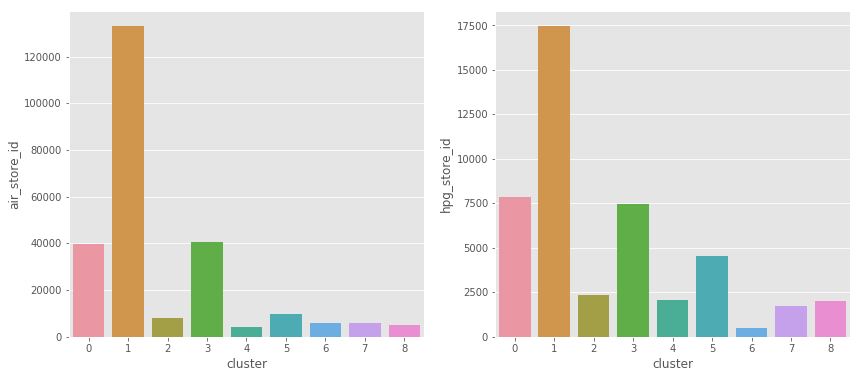

In [40]:
f,axa = plt.subplots(1,2,figsize=(14,6))
hist_clust = full.groupby(['cluster'],as_index=False).count()
sns.barplot(x=hist_clust.cluster,y=hist_clust.air_store_id,ax=axa[0])
sns.barplot(x=hist_clust.cluster,y=hist_clust.hpg_store_id,ax=axa[1])
plt.show()

On the map we can see by the color of the points that the classes are rightly spread out and distributed around the black points.<br>
Now we check which class number is equal to which region.

In [41]:
#separate the first part of the name of the region
full['prefecture'] = full['air_area_name'].map(lambda x: str(x).split(' ')[0])
full.head(5)

,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,air_area_name,hpg_store_id,reserve_visitors_hpg,hpg_date_diff,hpg_genre_name,hpg_area_name,air_store_id,latitude,longitude,cluster,prefecture
0,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to
1,2016-01-14,32,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to
2,2016-01-15,29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to
3,2016-01-16,22,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to
4,2016-01-18,6,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to


In [42]:
full.prefecture.unique()

array(['Tōkyō-to', 'Ōsaka-fu', 'Hokkaidō', 'Shizuoka-ken', 'Fukuoka-ken',
       'Hiroshima-ken', 'Hyōgo-ken', 'Niigata-ken', 'Miyagi-ken'],
      dtype=object)

In [43]:
aircluster = full.groupby(['prefecture','cluster',], as_index=False)['air_store_id'].count()
aircluster['percent'] = aircluster.air_store_id/aircluster.air_store_id.sum()*100
aircluster.head(9)
#we calculate what percentage of all restaurants are in each region

,prefecture,cluster,air_store_id,percent
0,Fukuoka-ken,0,39645,15.725403
1,Hiroshima-ken,5,9858,3.910229
2,Hokkaidō,2,7956,3.155790
3,Hokkaidō,8,5099,2.022546
4,Hyōgo-ken,3,17846,7.078712
5,Miyagi-ken,6,5959,2.363670
6,Niigata-ken,4,4063,1.611611
7,Shizuoka-ken,7,5798,2.299808
8,Tōkyō-to,1,133063,52.780158


Let's try to relate the identified groups with the biggest cities:

* Cluster 0 refers to Fukuoka-ken
* Cluster 1 refers  to Tōkyō-to
* Cluster 2 refers to Hokkaidō
* Cluster 3 refers to Hyōgo-ken
* Cluster 4 refers to Niigata-ken
* Cluster 5 referst to Hiroshima-ken
* Cluster 6 refers to Miyagi-ken
* Cluster 7 refers to Shizuoka-ken

In [44]:
aircluster.air_store_id.sum()

252108

In [45]:
full.head(5)

,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,air_area_name,hpg_store_id,reserve_visitors_hpg,hpg_date_diff,hpg_genre_name,hpg_area_name,air_store_id,latitude,longitude,cluster,prefecture
0,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to
1,2016-01-14,32,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to
2,2016-01-15,29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to
3,2016-01-16,22,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to
4,2016-01-18,6,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to


## Cousine Genres

Now let's check out wht are the genres appreciated in Japan. I have prepared two heatmaps: the former with thenumber of restaurants for each genre (columns) in each region (row) for thos with AIR reservation system; the latter with the HPG.
We are very interested in popularity by region and by genre.<br>
These are the main factors determining the choice!

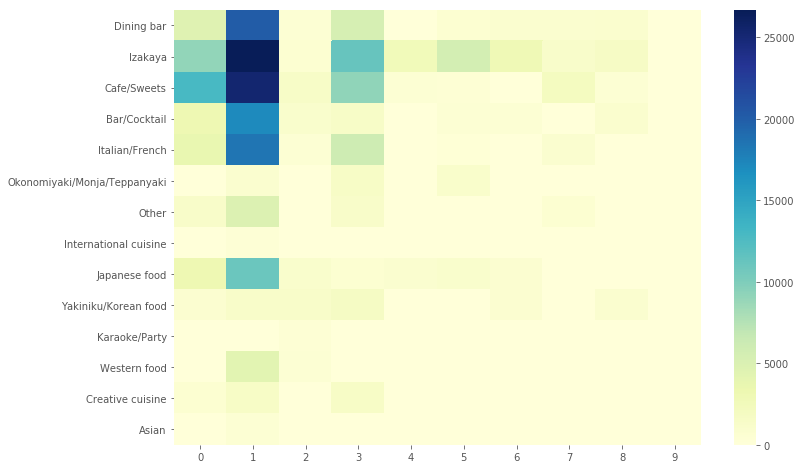

In [46]:
air_genre = full.loc[full.air_genre_name.isnull()==False].groupby(['cluster','air_genre_name'],as_index=False).count()
genres = full.air_genre_name.unique()

#i = 0
fig=plt.figure(figsize=(26,8))
ax2 = fig.add_subplot(122)
hm = []
for i in range(10):
    genres_count = [ air_genre.loc[air_genre.cluster==i].loc[air_genre.air_genre_name==name]['air_store_id'].values[0] if name in air_genre.loc[air_genre.cluster==i].air_genre_name.values else 0 for name in genres] 
    hm.append(genres_count)
hm = pd.DataFrame(hm,columns=genres,)
sns.heatmap(hm.transpose(),cmap="YlGnBu",ax=ax2)

plt.show()

From the resulting heat map we see that the most popular region is number "3"- Tōkyō-to and genre "Italian\French". <br>
Also we cen see that the in other region the most popula genre is "Izakaya". An izakaya (居酒屋) is a type of informal Japanese pub. They are casual places for after-work drinking. They have been compared to Irish pubs, tapas bars and early American saloons and taverns.<br>
And we cen see that the in other region one the most popula genre is "Cafe/Sweets".

## Japanese Holidays and date conversion

  At the stage ofdata analysis(EDA), we see that one of the important factors affecting the attendance of restaurants are day of the week, month and holidays.

I want to learn more about that so I will rely on this list https://www.officeholidays.com/countries/japan/index.php

* Jan 1st - **New Years day **;
* 2nd Monday of January - **Coming of Age day **: The day honors young Japanese who will reach the age of 20 at any point during the year. Twenty is the age of majority in Japan, and people who have reached this age gain the right to vote in elections as well as to drink;
* Feb 11th - **National Foundation day**:  a national holiday for Japanese people to remind themselves of the nation's founding and foster their love for the nation;
* March 20th or 21st- **Vernal Equinox day**: The day is intended to celebrate the love of nature and living things.In modern Japan, the day still maintains its older traditions as visiting family graves and holding family reunions is a common way of celebrating the equinox;
* April 29th - ** Showa day**: Showa Day honours the birthday of Emperor Hirohito, the reigning Emperor before, during, and after World War II (from 1926 - 1989);

In [47]:
#dates.rename(columns={'calendar_date':'visit_date'})
dates['visit_date']=dates['calendar_date']
dates.head(3)

,calendar_date,day_of_week,holiday_flg,visit_date
0,2016-01-01,Friday,1,2016-01-01
1,2016-01-02,Saturday,1,2016-01-02
2,2016-01-03,Sunday,1,2016-01-03


In [48]:
dates.drop(['calendar_date'], axis=1, inplace=True)

In [49]:
full.head()

,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,air_area_name,hpg_store_id,reserve_visitors_hpg,hpg_date_diff,hpg_genre_name,hpg_area_name,air_store_id,latitude,longitude,cluster,prefecture
0,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to
1,2016-01-14,32,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to
2,2016-01-15,29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to
3,2016-01-16,22,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to
4,2016-01-18,6,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to


In [50]:
#full.drop(['hpg_store_id','hpg_date_diff','hpg_genre_name','hpg_area_name','air_area_name'], axis=1, inplace=True)

In [51]:
full.drop(['hpg_genre_name','hpg_area_name'], axis=1, inplace=True)

In [52]:
full['visit_date'] = pd.to_datetime(full['visit_date'])

In [53]:
full['month'] = full['visit_date'].dt.month 
full['date'] = full['visit_date'].dt.day
full['dw'] = full['visit_date'].dt.dayofweek
full['dy'] = full['visit_date'].dt.dayofyear
full.head()

,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,air_area_name,hpg_store_id,reserve_visitors_hpg,hpg_date_diff,air_store_id,latitude,longitude,cluster,prefecture,month,date,dw,dy
0,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to,1,13,2,13
1,2016-01-14,32,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to,1,14,3,14
2,2016-01-15,29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to,1,15,4,15
3,2016-01-16,22,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to,1,16,5,16
4,2016-01-18,6,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to,1,18,0,18


In [54]:
dates['visit_date'] = pd.to_datetime(dates['visit_date'])
full['visit_date'] = pd.to_datetime(full['visit_date'])

In [55]:
nf = pd.merge(full, dates, how='left', on=['visit_date']) 
#nf = pd.merge(full,dates,on='visit_date', how='outer', validate="many_to_one")
nf.head()
#pd.merge(left, right, on='B', how='outer', validate="one_to_one")

,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,air_area_name,hpg_store_id,reserve_visitors_hpg,hpg_date_diff,air_store_id,latitude,longitude,cluster,prefecture,month,date,dw,dy,day_of_week,holiday_flg
0,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to,1,13,2,13,Wednesday,0
1,2016-01-14,32,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to,1,14,3,14,Thursday,0
2,2016-01-15,29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to,1,15,4,15,Friday,0
3,2016-01-16,22,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to,1,16,5,16,Saturday,0
4,2016-01-18,6,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,35.658068,139.751599,1,Tōkyō-to,1,18,0,18,Monday,0


In [56]:
nf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 20 columns):
visit_date              252108 non-null datetime64[ns]
visitors                252108 non-null int64
reserve_visitors_air    28064 non-null float64
air_date_diff           28064 non-null float64
air_genre_name          252108 non-null object
air_area_name           252108 non-null object
hpg_store_id            46019 non-null object
reserve_visitors_hpg    13550 non-null float64
hpg_date_diff           13550 non-null float64
air_store_id            252108 non-null object
latitude                252108 non-null float64
longitude               252108 non-null float64
cluster                 252108 non-null int32
prefecture              252108 non-null object
month                   252108 non-null int64
date                    252108 non-null int64
dw                      252108 non-null int64
dy                      252108 non-null int64
day_of_week             252108 non-null 

In [57]:
#nf.to_csv(r'C:\Users\sergey\Documents\Recruit Restaurant Visitor_2\nf.csv')

In [58]:
#we assign indexes for holiday, sunday, saturday.
nf['sunday'] = nf['visit_date'].dt.dayofweek.apply(lambda x:1 if x==6 else 0)
nf['saturday'] = nf['visit_date'].dt.dayofweek.apply(lambda x:1 if x==5 else 0)
nf['sat/sun/hol']=nf['holiday_flg']*1+nf['sunday']*0.5+nf['saturday']*0.3

nf2016 = nf[nf['visit_date'].dt.year==2016]
nf2017 = nf[nf['visit_date'].dt.year==2017]
nf.head()

,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,air_area_name,hpg_store_id,reserve_visitors_hpg,hpg_date_diff,air_store_id,...,prefecture,month,date,dw,dy,day_of_week,holiday_flg,sunday,saturday,sat/sun/hol
0,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,...,Tōkyō-to,1,13,2,13,Wednesday,0,0,0,0.0
1,2016-01-14,32,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,...,Tōkyō-to,1,14,3,14,Thursday,0,0,0,0.0
2,2016-01-15,29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,...,Tōkyō-to,1,15,4,15,Friday,0,0,0,0.0
3,2016-01-16,22,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,...,Tōkyō-to,1,16,5,16,Saturday,0,0,1,0.3
4,2016-01-18,6,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,...,Tōkyō-to,1,18,0,18,Monday,0,0,0,0.0


We can check how many days before the visit japenese people make the reservation.

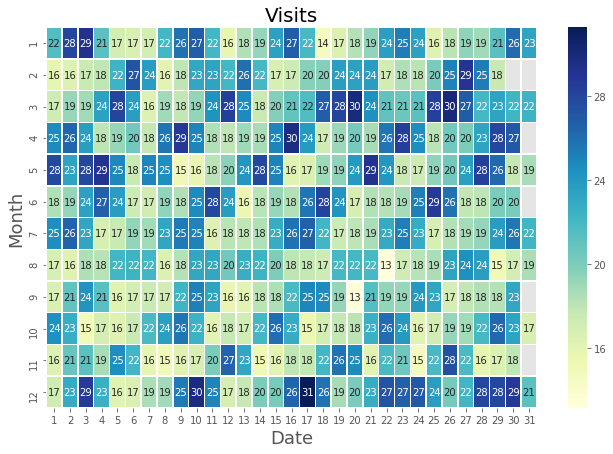

In [59]:
tb1=pd.pivot_table(nf2016,values='sat/sun/hol',index=['month'],columns=['date'])
tb2=pd.pivot_table(nf2016,values='visitors',index=['month'],columns=['date'])
fig=plt.figure(figsize=(22,7))
 

ax2 = fig.add_subplot(122)
sns.heatmap(tb2,annot=True, cmap="YlGnBu",linewidths='0.5',ax=ax2)
plt.title("Visits",fontsize=20)
plt.xlabel("Date",fontsize=18)
plt.ylabel("Month",fontsize=18)
fig.subplots_adjust(wspace=0.001)

In [60]:
nf.air_date_diff.describe()

count    28064.000000
mean         5.043561
std          8.534882
min          0.000000
25%          0.500000
50%          2.000000
75%          6.000000
max        349.500000
Name: air_date_diff, dtype: float64

In [61]:
nf.visitors.describe()

count    252108.000000
mean         20.973761
std          16.757007
min           1.000000
25%           9.000000
50%          17.000000
75%          29.000000
max         877.000000
Name: visitors, dtype: float64

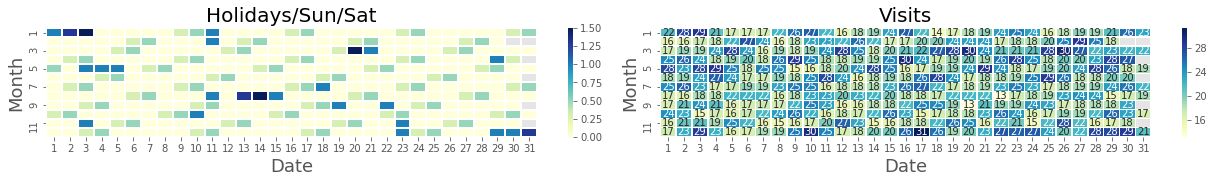

In [62]:
tb1=pd.pivot_table(nf2016,values='sat/sun/hol',index=['month'],columns=['date'])
tb2=pd.pivot_table(nf2016,values='visitors',index=['month'],columns=['date'])

fig=plt.figure(figsize=(22,2))
ax1 = fig.add_subplot(121)
sns.heatmap(tb1,cmap="YlGnBu",linewidths='1',ax=ax1)
plt.title("Holidays/Sun/Sat",fontsize=20)
plt.xlabel("Date",fontsize=18)
plt.ylabel("Month",fontsize=18)

ax2 = fig.add_subplot(122)
sns.heatmap(tb2,annot=True, cmap="YlGnBu",linewidths='0.5',ax=ax2)
plt.title("Visits",fontsize=20)
plt.xlabel("Date",fontsize=18)
plt.ylabel("Month",fontsize=18)
fig.subplots_adjust(wspace=0.001)

## Weather Data

In [63]:
wd.head()

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,1/1/16,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1
1,fukuoka_dazaifu-kana_dasaif,1/2/16,0.5,10.2,NaN,NaN,1.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.3,6.1
2,fukuoka_dazaifu-kana_dasaif,1/3/16,0.0,11.2,NaN,NaN,0.5,0.9,NaN,NaN,NaN,NaN,NaN,NaN,15.5,7.1
3,fukuoka_dazaifu-kana_dasaif,1/4/16,0.0,9.4,NaN,NaN,4.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,16.1,5.9
4,fukuoka_dazaifu-kana_dasaif,1/5/16,1.5,8.8,NaN,NaN,0.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,12.3,7.1


In [64]:
#separate the first part of the name of the region
wd['prefecture'] = wd['area_name'].map(lambda x: str(x).split('_')[0])
wd.head()

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature,prefecture
0,fukuoka_dazaifu-kana_dasaif,1/1/16,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1,fukuoka
1,fukuoka_dazaifu-kana_dasaif,1/2/16,0.5,10.2,NaN,NaN,1.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.3,6.1,fukuoka
2,fukuoka_dazaifu-kana_dasaif,1/3/16,0.0,11.2,NaN,NaN,0.5,0.9,NaN,NaN,NaN,NaN,NaN,NaN,15.5,7.1,fukuoka
3,fukuoka_dazaifu-kana_dasaif,1/4/16,0.0,9.4,NaN,NaN,4.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,16.1,5.9,fukuoka
4,fukuoka_dazaifu-kana_dasaif,1/5/16,1.5,8.8,NaN,NaN,0.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,12.3,7.1,fukuoka


In [65]:
wdmytest = wd.groupby(['prefecture'], as_index=False)['avg_temperature'].mean()
wdmytest.head(15)

,prefecture,avg_temperature
0,fukuoka,15.728844
1,hiroshima,14.317344
2,hokkaido,5.872029
3,hyogo,14.592747
4,kanagawa,15.356673
5,miyagi,11.087105
6,niigata,12.433745
7,osaka,14.812773
8,saitama,13.533269
9,shizuoka,15.470068


Let's try to relate the identified groups with the biggest cities:

* Cluster 0 refers to Fukuoka-ken
* Cluster 1 refers  to Tōkyō-to
* Cluster 2 refers to Hokkaidō
* Cluster 3 refers to Hyōgo-ken
* Cluster 4 refers to Niigata-ken
* Cluster 5 referst to Hiroshima-ken
* Cluster 6 refers to Miyagi-ken
* Cluster 7 refers to Shizuoka-ken

In [66]:
import re
def area2group(area):
    if re.match(r'tokyo.*',area) !=None:
        return 1
    if re.match(r'hyogo.*',area) !=None:
        return 3
    if re.match(r'hokkaido.*',area) !=None:
        return 2    
    if re.match(r'fukuoka.*',area) !=None:
        return 0
    if re.match(r'niigata.*',area) !=None:
        return 4
    if re.match(r'hiroshima.*',area) !=None:
        return 5
    if re.match(r'shizuoka.*',area) !=None:
        return 7
    if re.match(r'miyagi.*',area) !=None:
        return 6
    else:
        return -1

warea = [area2group(area) for area in wd.area_name]
wd['cluster'] = warea
#re.match(r'fukuoka.*',wd.area_name[0])
#wd.area_name

In [67]:
wd['calendar_date'] = pd.to_datetime(wd.calendar_date).dt.date
wd.head()

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature,prefecture,cluster
0,fukuoka_dazaifu-kana_dasaif,2016-01-01,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1,fukuoka,0
1,fukuoka_dazaifu-kana_dasaif,2016-01-02,0.5,10.2,NaN,NaN,1.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.3,6.1,fukuoka,0
2,fukuoka_dazaifu-kana_dasaif,2016-01-03,0.0,11.2,NaN,NaN,0.5,0.9,NaN,NaN,NaN,NaN,NaN,NaN,15.5,7.1,fukuoka,0
3,fukuoka_dazaifu-kana_dasaif,2016-01-04,0.0,9.4,NaN,NaN,4.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,16.1,5.9,fukuoka,0
4,fukuoka_dazaifu-kana_dasaif,2016-01-05,1.5,8.8,NaN,NaN,0.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,12.3,7.1,fukuoka,0


In [68]:
wdg = wd.groupby(['cluster','calendar_date'],as_index=False).mean()
wdg.head()

,cluster,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,-1,2016-01-01,0.0,6.36,NaN,NaN,8.4125,2.09,5.966667,55.333333,1028.500000,1022.500000,11.215,2.833333,11.13,2.35
1,-1,2016-01-02,0.0,7.46,NaN,NaN,5.6250,1.78,7.366667,62.666667,1024.100000,1018.166667,7.080,6.433333,13.02,2.44
2,-1,2016-01-03,0.0,9.84,NaN,NaN,6.0125,1.52,9.533333,71.000000,1018.500000,1012.600000,8.080,6.266667,15.52,5.91
3,-1,2016-01-04,0.0,10.08,NaN,NaN,6.7250,2.06,9.033333,66.333333,1017.433333,1011.533333,9.305,1.600000,15.13,5.07
4,-1,2016-01-05,0.0,9.01,NaN,NaN,3.1750,1.74,7.866667,62.333333,1020.200000,1014.333333,3.080,6.433333,12.27,5.57


In [69]:
nf['visit_date']=pd.to_datetime(nf.visit_date).dt.date
nf.head()

,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,air_area_name,hpg_store_id,reserve_visitors_hpg,hpg_date_diff,air_store_id,...,prefecture,month,date,dw,dy,day_of_week,holiday_flg,sunday,saturday,sat/sun/hol
0,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,...,Tōkyō-to,1,13,2,13,Wednesday,0,0,0,0.0
1,2016-01-14,32,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,...,Tōkyō-to,1,14,3,14,Thursday,0,0,0,0.0
2,2016-01-15,29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,...,Tōkyō-to,1,15,4,15,Friday,0,0,0,0.0
3,2016-01-16,22,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,...,Tōkyō-to,1,16,5,16,Saturday,0,0,1,0.3
4,2016-01-18,6,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,...,Tōkyō-to,1,18,0,18,Monday,0,0,0,0.0


In [91]:
wnf = pd.merge(nf,wdg,left_on=['cluster','visit_date'], right_on=['cluster','calendar_date'])
#wnf = pd.merge(wdg,nf,left_on=['cluster','calendar_date'],right_on=['cluster','visit_date'])
wnf.head()

,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,air_area_name,hpg_store_id,reserve_visitors_hpg,hpg_date_diff,air_store_id,...,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_ba937bf13d40fb24,...,8.833333,1.514286,4.9,60.0,1013.1,1010.1,10.86,2.5,9.171429,-2.028571
1,2016-01-13,21,NaN,NaN,Izakaya,Tōkyō-to Shinagawa-ku Higashigotanda,NaN,NaN,NaN,air_25e9888d30b386df,...,8.833333,1.514286,4.9,60.0,1013.1,1010.1,10.86,2.5,9.171429,-2.028571
2,2016-01-13,40,NaN,NaN,Izakaya,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_fd6aac1043520e83,...,8.833333,1.514286,4.9,60.0,1013.1,1010.1,10.86,2.5,9.171429,-2.028571
3,2016-01-13,5,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_64d4491ad8cdb1c6,...,8.833333,1.514286,4.9,60.0,1013.1,1010.1,10.86,2.5,9.171429,-2.028571
4,2016-01-13,16,NaN,NaN,Other,Tōkyō-to Shibuya-ku Shibuya,NaN,NaN,NaN,air_5c65468938c07fa5,...,8.833333,1.514286,4.9,60.0,1013.1,1010.1,10.86,2.5,9.171429,-2.028571


In [71]:
print("There are",len(wnf.air_store_id.unique()),"restaurants in the AIR network, of which",len(wnf.reserve_visitors_air.unique()),"was pre-booked in AIR and",len(wnf.reserve_visitors_hpg.unique()),"in HPG.")

There are 812 restaurants in the AIR network, of which 117 was pre-booked in AIR and 77 in HPG.


In [92]:
copywnf = wnf.copy()

In [90]:
#wnf.head(2)
wnf.shape

(247009, 38)

In [ ]:
wnf['reserve_visitors_air'] = wnf['reserve_visitors_air'].fillna(0)
wnf['reserve_visitors_hpg'] = wnf['reserve_visitors_hpg'].fillna(0)

In [ ]:
wnf['reserve_visitors_sum'] = wnf['reserve_visitors_air']. + wnf['reserve_visitors_hpg']
wnf['reserve_visitors_mean'] = (wnf['reserve_visitors_air'] + wnf['reserve_visitors_hpg']) / 2
wnf['date_diff_mean'] = (wnf['air_date_diff'] + wnf['hpg_date_diff']) / 2

In [73]:
wnf['lon_plus_lat'] = wnf['longitude'] + wnf['latitude'] 

In [74]:
wnf.loc[wnf.reserve_visitors_air > 0]

,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,air_area_name,hpg_store_id,reserve_visitors_hpg,hpg_date_diff,air_store_id,...,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature,reserve_visitors_sum,reserve_visitors_mean,date_diff_mean,lon_plus_lat
26,2016-01-13,14,2.0,0.0,Italian/French,Tōkyō-to Shibuya-ku Shibuya,NaN,NaN,NaN,air_f911308e19d64236,...,1013.100,1010.100,10.8600,2.500,9.171429,-2.028571,NaN,NaN,NaN,175.365828
30,2016-01-13,17,8.0,4.5,Japanese food,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_877f79706adbfb06,...,1013.100,1010.100,10.8600,2.500,9.171429,-2.028571,NaN,NaN,NaN,175.409667
39,2016-01-13,2,2.0,0.0,Italian/French,Tōkyō-to Minato-ku Shibakōen,NaN,NaN,NaN,air_6b9fa44a9cf504a1,...,1013.100,1010.100,10.8600,2.500,9.171429,-2.028571,NaN,NaN,NaN,175.409667
40,2016-01-13,12,12.0,0.0,Italian/French,Tōkyō-to Minato-ku Shibakōen,hpg_c5ec63f52e4a7e9e,NaN,NaN,air_290e7a57b390f78e,...,1013.100,1010.100,10.8600,2.500,9.171429,-2.028571,NaN,NaN,NaN,175.409667
49,2016-01-13,31,17.0,3.5,Izakaya,Tōkyō-to Shibuya-ku Shibuya,hpg_43a5666d1b6fa70b,NaN,NaN,air_b9e27558fb8bd5c4,...,1013.100,1010.100,10.8600,2.500,9.171429,-2.028571,NaN,NaN,NaN,175.365828
85,2016-01-13,12,4.0,9.0,Japanese food,Tōkyō-to Chūō-ku Tsukiji,NaN,NaN,NaN,air_0b184ec04c741a6a,...,1013.100,1010.100,10.8600,2.500,9.171429,-2.028571,NaN,NaN,NaN,175.442512
89,2016-01-13,25,21.0,7.0,Izakaya,Tōkyō-to Chūō-ku Tsukiji,hpg_583dddac1a035048,NaN,NaN,air_54ed43163b7596c4,...,1013.100,1010.100,10.8600,2.500,9.171429,-2.028571,NaN,NaN,NaN,175.442512
105,2016-01-13,31,8.0,0.0,Izakaya,Tōkyō-to Kōtō-ku Kameido,hpg_f83413cde79ac5e7,NaN,NaN,air_4cca5666eaf5c709,...,1013.100,1010.100,10.8600,2.500,9.171429,-2.028571,NaN,NaN,NaN,175.526109
115,2016-01-13,46,26.0,0.5,Yakiniku/Korean food,Tōkyō-to Chūō-ku Ginza,hpg_874415e6e7ccfe13,NaN,NaN,air_8093d0b565e9dbdf,...,1013.100,1010.100,10.8600,2.500,9.171429,-2.028571,NaN,NaN,NaN,175.442940
167,2016-01-14,22,7.0,0.0,Italian/French,Tōkyō-to Shibuya-ku Shibuya,NaN,NaN,NaN,air_f911308e19d64236,...,1011.900,1008.900,12.0900,0.500,11.185714,-1.271429,NaN,NaN,NaN,175.365828


### Missing values

Missing Values
Now that we have the correct column datatypes, we can start analysis by looking at the percentage of missing values in each column. Missing values are fine when we do Exploratory Data Analysis, but they will have to be filled in for machine learning methods.<br>

Following is a function that calculates the number of missing values and the percentage of the total values that are missing for each column. As with many tasks in data science, I did not write this function myself, but rather found it online in a Stack Overflow forum!

In [75]:
# See the column data types and non-missing values
wnf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247009 entries, 0 to 247008
Data columns (total 42 columns):
visit_date               247009 non-null object
visitors                 247009 non-null int64
reserve_visitors_air     26729 non-null float64
air_date_diff            26729 non-null float64
air_genre_name           247009 non-null object
air_area_name            247009 non-null object
hpg_store_id             44029 non-null object
reserve_visitors_hpg     12888 non-null float64
hpg_date_diff            12888 non-null float64
air_store_id             247009 non-null object
latitude                 247009 non-null float64
longitude                247009 non-null float64
cluster                  247009 non-null int32
prefecture               247009 non-null object
month                    247009 non-null int64
date                     247009 non-null int64
dw                       247009 non-null int64
dy                       247009 non-null int64
day_of_week              24700

In [76]:
# Function to calculate missing values by column
def missing_values_table(wnf):
        # Total missing values
        mis_val = wnf.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * wnf.isnull().sum() / len(wnf)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(wnf.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [77]:
missing_values_table(wnf)

Your selected dataframe has 42 columns.
There are 13 columns that have missing values.


,Missing Values,% of Total Values
reserve_visitors_sum,241463,97.8
reserve_visitors_mean,241463,97.8
date_diff_mean,241463,97.8
reserve_visitors_hpg,234121,94.8
hpg_date_diff,234121,94.8
total_snowfall,228574,92.5
deepest_snowfall,227307,92.0
reserve_visitors_air,220280,89.2
air_date_diff,220280,89.2
hpg_store_id,202980,82.2


Although we want to be careful to not discard information and should be careful when dropping columns, if a column has a high percentage of missing values, then it probably will not be of much use.<br>
We do not want to delete variables or replace them with synthetic data.<br>
This is objective data because there is : "Total snowfall" and "Deepest snowfall". It's snowing in japan only in winter.This is less than half of our data.We also make a forecast for the spring.<br> 
And the number of orders less than the number of visitors.

## Outliers

To determine outliers, let's use a widely used measure of the Z-score. The idea is to calculate how many standard deviations this particular value differs from the mean. It is assumed that values with an estimate of Z above 3 are outliers. 

On the low end, an extreme outlier is below  $\text{First Quartile} -3 * \text{Interquartile Range}$
On the high end, an extreme outlier is above $\text{Third Quartile} + 3 * \text{Interquartile Range}$

In [78]:
def outliers(wnf):
    df_0 = wnf.loc[wnf.visitors == 0]   
    q1 = np.percentile(wnf.visitors, 25, axis=0)
    q3 = np.percentile(wnf.visitors, 75, axis=0)
#    k = 5
#    k = 2.5
    k = 2.8
#    k = 2
#    k = 1.5
    iqr = q3 - q1
    df_temp = data.loc[wnf.visitors > q1 - k*iqr]
    df_temp = data.loc[wnf.visitors < q3 + k*iqr]
    frames = [df_0, df_temp]
    wnf['outliers'] = pd.concat(frames)
    return result_outliers

In [79]:
#wnf.to_csv(r'C:\Users\sergey\Documents\Recruit Restaurant Visitor_2\wnf.csv')

## Variable selection

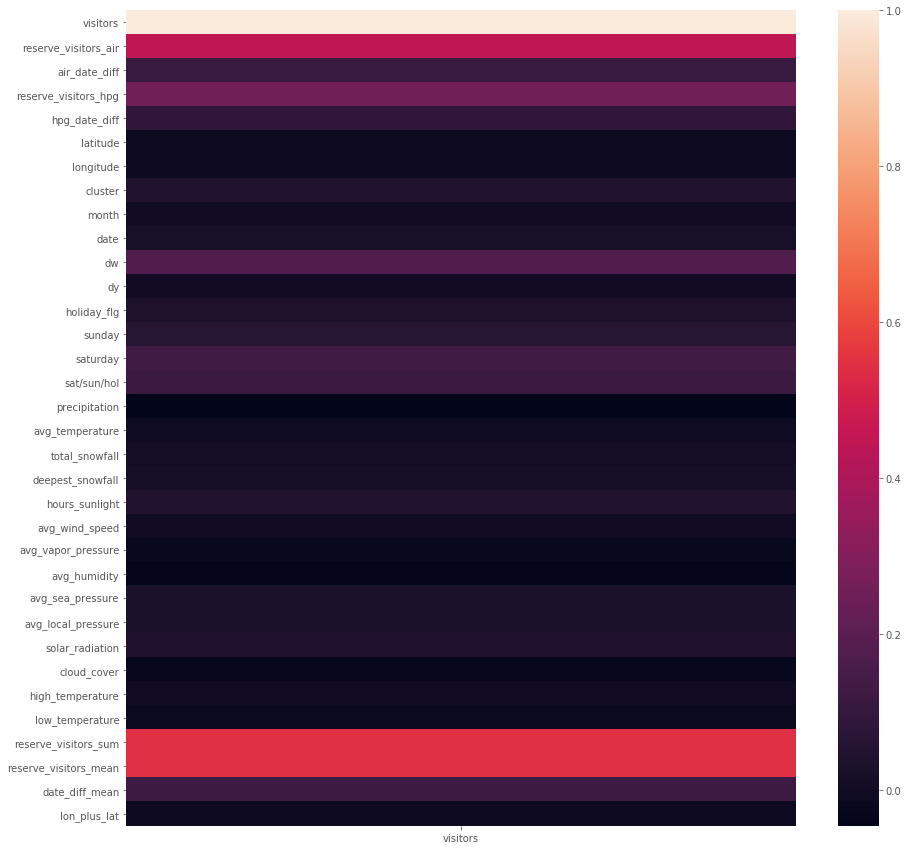

In [80]:
f,axa = plt.subplots(1,1,figsize=(15,15))
sns.heatmap(wnf.corr()[['visitors']])

In [81]:
#lbl = preprocessing.LabelEncoder()
#stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
#stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

In [82]:
#col = [c for c in train if c not in ['id', 'air_store_id','visit_date','visitors']]
#print(train.describe())
#print(train.head())
#train = train.fillna(-1)
#test = test.fillna(-1)
#def RMSLE(y, pred):
   # return metrics.mean_squared_error(y, pred)**0.5

In [83]:
#from sklearn.model_selection import train_test_split

#features= [c for c in train.columns.values if c  not in ['air_store_id', 'visitors']]
#numeric_features= [c for c in df.columns.values if c  not in ['id','text','author','processed']]
#target = 'author'

#X_train, X_val, y_train, y_val = train_test_split(train[col], train['visitors'], test_size=0.33, random_state=42)
#X_train.head()

In [84]:
#y_train_data = visit_data.loc[visit_data['visit_date']<'2017-04-01','visitors']
#y_test_data = visit_data.loc[visit_data['visit_date']>='2017-04-01','visitors']

In [85]:
#train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
#test['lon_plus_lat'] = test['longitude'] + test['latitude']